<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-and-prepare-data" data-toc-modified-id="Import-and-prepare-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import and prepare data</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random Forest</a></span><ul class="toc-item"><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Feature importance</a></span><ul class="toc-item"><li><span><a href="#sklearn-feature-importance-(Gini)" data-toc-modified-id="sklearn-feature-importance-(Gini)-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>sklearn feature importance (Gini)</a></span></li><li><span><a href="#Permutation-Feature-importance" data-toc-modified-id="Permutation-Feature-importance-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Permutation Feature importance</a></span></li><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>SHAP</a></span></li><li><span><a href="#Putting-together" data-toc-modified-id="Putting-together-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Putting together</a></span><ul class="toc-item"><li><span><a href="#Sklearn" data-toc-modified-id="Sklearn-2.1.4.1"><span class="toc-item-num">2.1.4.1&nbsp;&nbsp;</span>Sklearn</a></span></li><li><span><a href="#Permutation" data-toc-modified-id="Permutation-2.1.4.2"><span class="toc-item-num">2.1.4.2&nbsp;&nbsp;</span>Permutation</a></span></li><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1.4.3"><span class="toc-item-num">2.1.4.3&nbsp;&nbsp;</span>SHAP</a></span></li></ul></li></ul></li><li><span><a href="#Contributions-of-features" data-toc-modified-id="Contributions-of-features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Contributions of features</a></span><ul class="toc-item"><li><span><a href="#Treeinterpreter" data-toc-modified-id="Treeinterpreter-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Treeinterpreter</a></span></li><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>SHAP</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Comparison</a></span></li></ul></li><li><span><a href="#Explore-feature-relations-vs-pdp" data-toc-modified-id="Explore-feature-relations-vs-pdp-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Explore feature relations vs pdp</a></span><ul class="toc-item"><li><span><a href="#pdpbox" data-toc-modified-id="pdpbox-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>pdpbox</a></span></li><li><span><a href="#SHAP-dependencies-plot" data-toc-modified-id="SHAP-dependencies-plot-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>SHAP dependencies plot</a></span></li></ul></li></ul></li><li><span><a href="#Bonus-TreeInterpreter-Feature-Importance" data-toc-modified-id="Bonus-TreeInterpreter-Feature-Importance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bonus TreeInterpreter Feature Importance</a></span></li><li><span><a href="#Archive" data-toc-modified-id="Archive-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Archive</a></span><ul class="toc-item"><li><span><a href="#Test-on-redundant-features" data-toc-modified-id="Test-on-redundant-features-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Test on redundant features</a></span></li><li><span><a href="#MAE-vs-MSE-feature-importance" data-toc-modified-id="MAE-vs-MSE-feature-importance-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>MAE vs MSE feature importance</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li></ul></div>

# Import and prepare data


In [1]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [2]:
import xgboost
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 1000)

## Prepare Data

In [3]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [4]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [5]:
df_trn.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
MachineID,401125,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,401125,NaN,NaN,NaN,6.32733,16.5751,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,401125,NaN,NaN,NaN,1230.73,16542.9,0,0,0,0,2.4833e+06
UsageBand,401125,NaN,NaN,NaN,-0.623898,0.870291,-1,-1,-1,-1,2
fiModelDesc,401125,NaN,NaN,NaN,1673.71,1263.33,1,631,1395,2292,4999
fiBaseModel,401125,NaN,NaN,NaN,559.165,469.31,1,206,406,704,1950


# Random Forest

In [6]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_, 'std':np.std([tree.feature_importances_ for tree in m.estimators_],
             axis=0)}
                       ).sort_values('imp', ascending=False)

In [7]:
def plot_fi(fi,std=True, feature_importance_type=''):
    if std:
        ax = fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, xerr='std')
    else:
        ax = fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
    
    ax.set_xlabel(f"{feature_importance_type} Feature Importance")
    return ax

In [8]:
set_rf_samples(50000)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20607516700458903, 0.2504207366152017, 0.91124636542035586, 0.88800760008028823, 0.89416603927838945]


## Feature importance

For the sake of interpretation, we use a subset to speed up computation

In [13]:
n = 1000
sample_idx = np.random.permutation(len(X_valid))[:n]

In [14]:
X_valid_sample = X_valid.iloc[sample_idx].copy()
y_valid_sample = y_valid[sample_idx].copy()
X_valid_sample.shape, y_valid_sample.shape


((1000, 66), (1000,))

### sklearn feature importance (Gini)

In [15]:
fi_sklearn = rf_feat_importance(m, X_valid_sample); fi_sklearn[:10]

,cols,imp,std
5,YearMade,0.170900,0.022382
37,Coupler_System,0.107031,0.099127
13,ProductSize,0.094212,0.047293
14,fiProductClassDesc,0.078732,0.039969
2,ModelID,0.054950,0.021318
63,saleElapsed,0.049756,0.005392
38,Grouser_Tracks,0.049630,0.086771
10,fiSecondaryDesc,0.044861,0.020753
39,Hydraulics_Flow,0.041284,0.082109
19,Enclosure,0.039521,0.040465


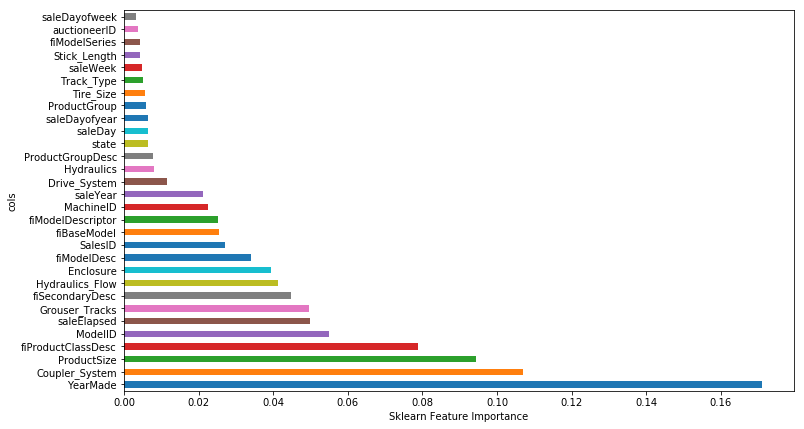

In [16]:
plot_fi(fi_sklearn[:30],False, 'Sklearn');

### Permutation Feature importance

In [17]:
from rfpimp import importances
fi_permutation = importances(m, X_valid_sample, y_valid_sample) # permutation

In [18]:
fi_permutation.sum()

Importance    1.218516
dtype: float64

I am not sure why it does not sum up to 1, normalize it for now

In [19]:
fi_permutation['Importance'] = fi_permutation['Importance']/ fi_permutation['Importance'].sum()

In [20]:
fi_permutation.sum()

Importance    1.0
dtype: float64

In [21]:
fi_permutation = (fi_permutation
                  .reset_index()
                  .rename({'Feature':'cols', 'Importance':'imp'},axis=1))

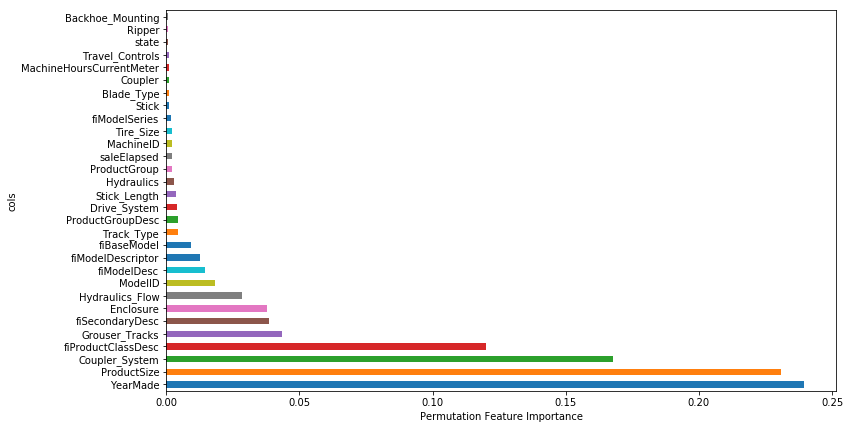

In [22]:
plot_fi(fi_permutation[:30],False,'Permutation')

### SHAP

Notice that the computation is quite slow for RandomForest, it seems run faster on XGboost, LightGBM etc.

In [24]:
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(X_valid_sample.values.astype(int))

explainer.expected_value

10.105362202272051

In [25]:
explainer.expected_value

10.105362202272051

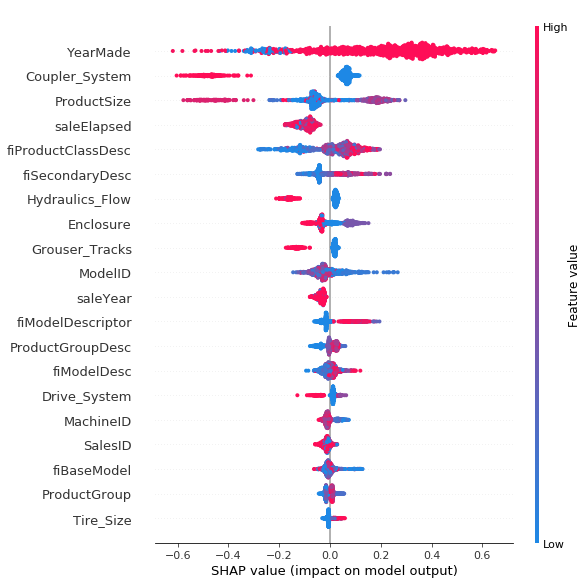

In [26]:
shap.summary_plot(shap_values, X_valid_sample)

In https://github.com/slundberg/shap, it suggest you can plot the _mean absoulte SHAP value_, so I suppose it is OK to normalize the SHAP value and make a similar plot as before

In [27]:
# sum over each feature
fi_shap = abs(shap_values).sum(0)

# Normalize
fi_shap = fi_shap/fi_shap.sum() ; 
fi_shap.sum(),fi_shap.shape

(1.0, (66,))

In [28]:
fi_shap = (pd.DataFrame({'cols':X_valid_sample.columns, 'imp':fi_shap })
           .sort_values('imp', ascending=False))

In [29]:
fi_shap.head(3)

,cols,imp
5,YearMade,0.210351
37,Coupler_System,0.121832
13,ProductSize,0.112231


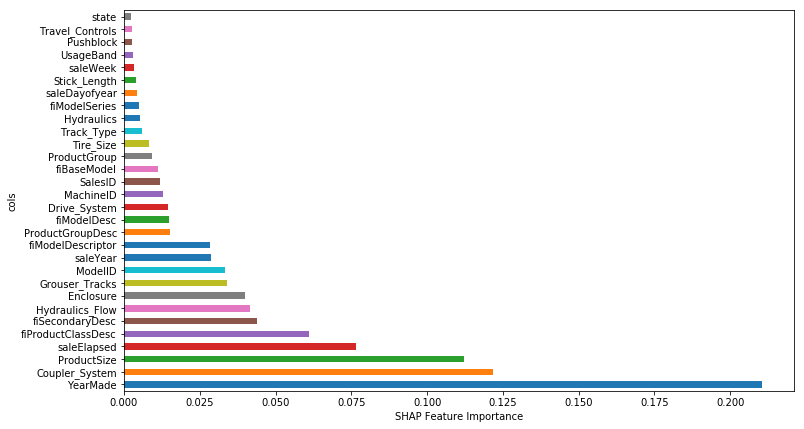

In [30]:
plot_fi(fi_shap[:30], False, 'SHAP')

### Putting together

#### Sklearn 

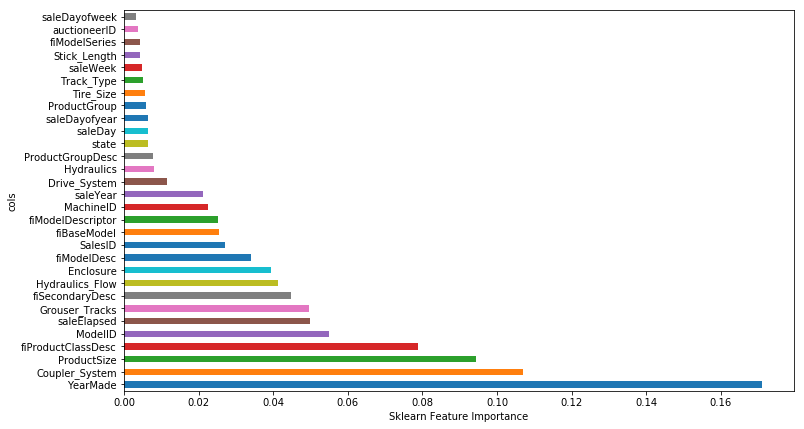

In [23]:
plot_fi(fi_sklearn[:30],False, "Sklearn");

#### Permutation

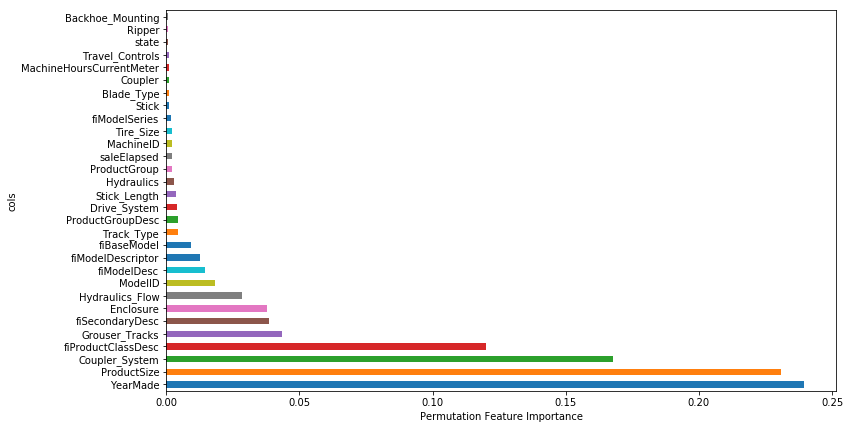

In [24]:
plot_fi(fi_permutation[:30],False, "Permutation");

#### SHAP

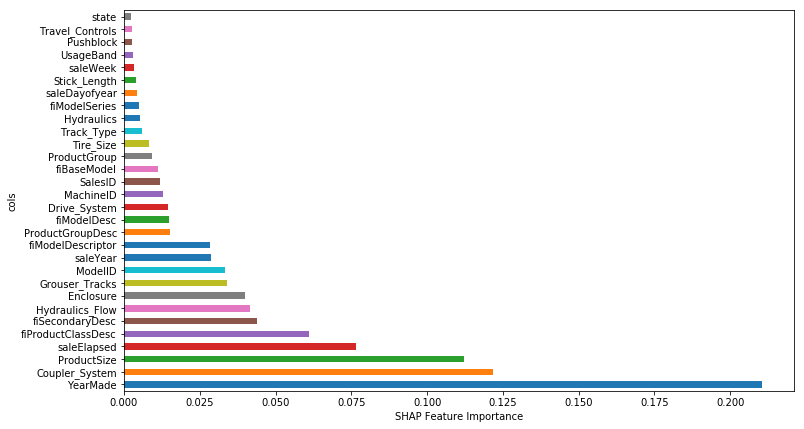

In [33]:
plot_fi(fi_shap[:30],False, "SHAP");

In [34]:
fi_df = fi_sklearn.sort_values('cols').copy()
fi_df['imp'].rename('Sklearn imp', axis=1, inplace=True)
fi_df['permutation imp'] = fi_permutation.sort_values('cols')['imp'].copy()
fi_df['SHAP imp'] = fi_shap.sort_values('cols')['imp'].copy()
fi_df.drop('std', axis=1, inplace=True)
fi_df.sort_values('SHAP imp', ascending=False, inplace=True)


In [35]:
fi_df.head(10)

,cols,imp,permutation imp,SHAP imp
5,YearMade,0.175381,0.033108,0.210351
37,Coupler_System,0.115121,0.000276,0.121832
13,ProductSize,0.103851,0.004242,0.112231
63,saleElapsed,0.051154,-0.000183,0.076429
14,fiProductClassDesc,0.077293,0.003973,0.060901
10,fiSecondaryDesc,0.044643,0.011632,0.043858
39,Hydraulics_Flow,0.041484,0.000253,0.041667
19,Enclosure,0.030680,0.002077,0.039908
38,Grouser_Tracks,0.032391,0.000255,0.033907
2,ModelID,0.057929,0.209657,0.033187


## Contributions of features

### Treeinterpreter

In [25]:
from treeinterpreter import treeinterpreter as ti
from waterfall import waterfall_chart  # https://github.com/chrispaulca/waterfall , clone as local repo

In [26]:
row = X_valid_sample.values[None,0]; row
prediction, bias, contributions = ti.predict(m, row)

In [30]:
contribution_df = pd.DataFrame([X_valid_sample.iloc[0].values, contributions[0]], columns=X_valid_sample.columns,index=['Feature_values','TreeInterpreterContribution']).T

Text(29,0.5,'Change on y')

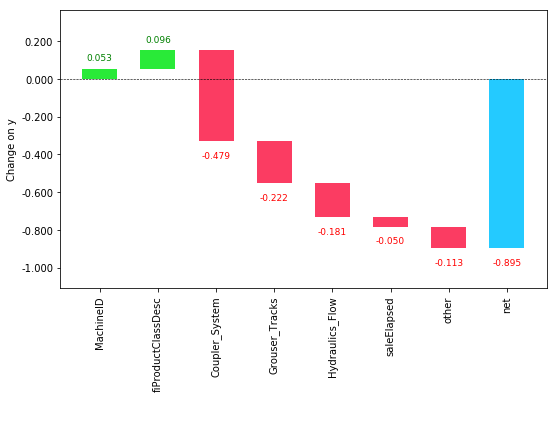

In [31]:
ti_plot = waterfall_chart.plot(X_valid_sample.columns.values,contributions[0], rotation_value=90, threshold=0.1,formatting='{:,.3f}',figsize=(8,6))
plt.ylabel('Change on y')

In [ ]:
my_plot

### SHAP

In [46]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [47]:
contribution_df['SHAPContribution'] = np.array(shap_values[0,:],dtype=object)

In [48]:
#### The 5 most important features for SHAP
contribution_df.sort_values('SHAPContribution')['SHAPContribution'].head(10).index

Index(['ProductSize', 'saleElapsed', 'fiProductClassDesc', 'saleYear',
       'SalesID', 'fiModelDescriptor', 'Enclosure', 'fiBaseModel', 'Tire_Size',
       'fiModelDesc'],
      dtype='object')

In [49]:
#### The 5 most important features for Treeinterpreter
contribution_df.sort_values('SHAPContribution')['TreeInterpreterContribution'].head(10).index

Index(['ProductSize', 'saleElapsed', 'fiProductClassDesc', 'saleYear',
       'SalesID', 'fiModelDescriptor', 'Enclosure', 'fiBaseModel', 'Tire_Size',
       'fiModelDesc'],
      dtype='object')

The rank of feature contribution looks similar, but value are not always close

In [50]:
contribution_df.sort_values('SHAPContribution').head(5)

,Feature_values,TreeInterpreterContribution,SHAPContribution
ProductSize,5,-0.610784,-0.440641
saleElapsed,1.2846e+09,-0.0600961,-0.0998432
fiProductClassDesc,17,-0.0304155,-0.0471628
saleYear,2010,-0.0239873,-0.0449892
SalesID,4.36475e+06,-0.0798219,-0.0372894


### Comparison

It is easier to compare both SHAP and treeinterpreter with waterfall chart with sorted order

Text(0.5,1,'Tree Interpreter')

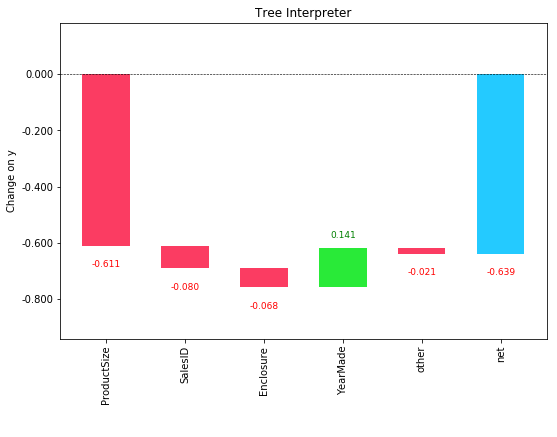

In [104]:
ti_plot = waterfall_chart.plot(X_valid_sample.columns[contributions.argsort()],
                               contributions[0][contributions.argsort()],
                               rotation_value=90, threshold=0.1,formatting='{:,.3f}',figsize=(8,6))
plt.ylabel('Change on y')
plt.title('Tree Interpreter')

Text(0.5,1,'SHAP')

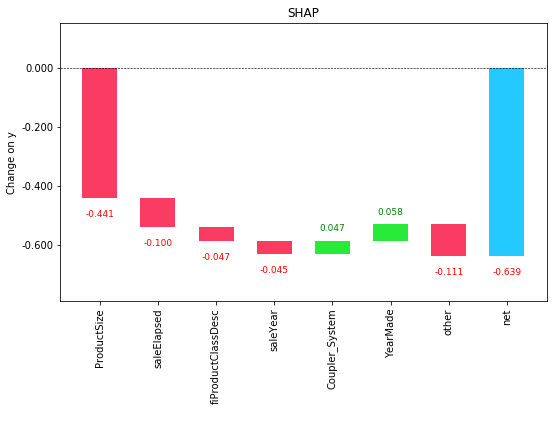

In [103]:
shap_plot = waterfall_chart.plot(X_valid_sample.columns[shap_values[0,:].argsort()],shap_values[0,:][shap_values[0,:].argsort()], rotation_value=90, threshold=0.1,formatting='{:,.3f}',figsize=(8,6))
plt.ylabel('Change on y')
plt.title('SHAP')

## Explore feature relations vs pdp

### pdpbox

In [ ]:
from pdpbox import pdp
from plotnine import *

In [ ]:
def plot_pdp(feat, df,clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, df, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

In [ ]:
X_train.shape, X_valid.shape

To remove the outlier of "YearMade" features, we only plot data with YearMade>1930 to get a better view.

In [ ]:
plot_pdp('YearMade', X_valid_sample[X_valid_sample['YearMade']>1930], clusters=5)

### SHAP dependencies plot

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("YearMade", shap_values[X_valid_sample['YearMade']>1930],
                     X_valid_sample[X_valid_sample['YearMade']>1930])

# Bonus TreeInterpreter Feature Importance
Inspired by the SHAP Value, which we can add up indivual rows contribution to get a feature importance, I attempt to do the same for treeinterpreter

In [52]:
row = X_valid_sample.values; row
prediction, bias, contributions = ti.predict(m, row)

In [54]:
# contributions_backup = contributions.copy()

In [55]:
contributions = abs(contributions).sum(0)

In [69]:
contribution_df = pd.DataFrame([X_valid_sample.columns, contributions],index=['cols','imp']).T
contribution_df['imp'] = contribution_df['imp']/contribution_df['imp'].sum() # Normalize

Notice that the first graph here is generated by summingup invidual rows contribution, and the second graph is the default MSE variance reduction feature importance for sklearn, they are very similar.

Text(0.5,1,'Summing up contributions of treeinterpreter')

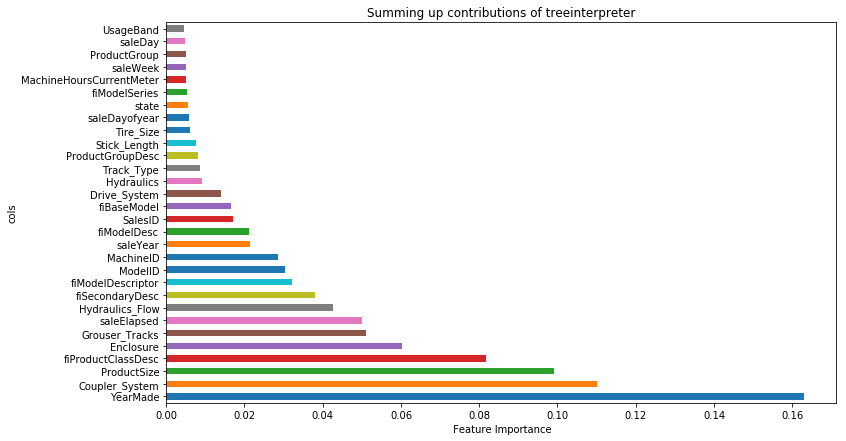

In [83]:
plot_fi(contribution_df.sort_values('imp',ascending=False).head(30),False)
plt.title('Summing up contributions of treeinterpreter')

Text(0.5,1,'sklearn default gini impurity feature importance')

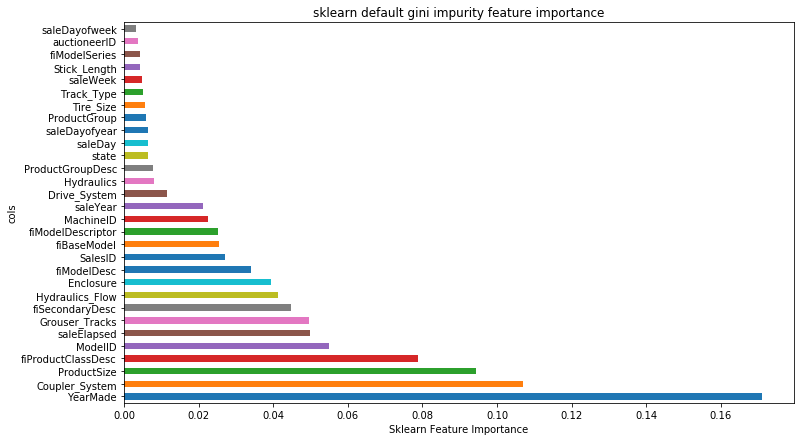

In [84]:
# Recall the sklearn feature importance...
plot_fi(fi_sklearn[:30],False, "Sklearn");
plt.title('sklearn default gini impurity feature importance')

In [ ]:
m.fe

# Archive

## Test on redundant features

## MAE vs MSE feature importance
Repeat the above process, to confirm it should have consistent behavior with different losses.

## XGBoost

In [ ]:
X_train.iloc[0:1]

In [ ]:
# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(X_train.iloc[0:1])

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
X.dtypes

In [ ]:
tree = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
tree.fit(X, y)


In [ ]:
X_xgb = xgboost.DMatrix(X)

In [ ]:
%time model.predict(X_xgb,ntree_limit=100)

In [ ]:
%time m.predict(X)

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
explainer.shap_values??

In [ ]:
shap_values[0,:]

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])